In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
artists = pd.read_csv("artists.dat", delimiter="\t")
user_artists = pd.read_csv("user_artists.dat", delimiter="\t")
user_tagged_artists = pd.read_csv("user_taggedartists.dat", delimiter="\t")
tags = pd.read_csv("tags.dat", delimiter="\t", encoding="ISO-8859-1")
user_friends = pd.read_csv("user_friends.dat", delimiter="\t")

### Plot the distribution of play counts per artist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C580F0D128>]],
      dtype=object)

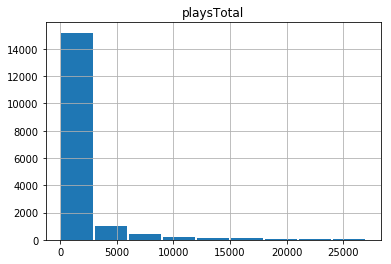

In [19]:
play_counts_by_artist = user_artists.groupby("artistID")\
                            .weight.agg(["sum"])\
                            .rename(columns={"name": "artistName", "sum": "playsTotal"})

# Exclude artists that had more than 30000 plays. Those artists only represent ~2% of all artists in the dataset.
play_counts_by_artist.reset_index()\
    .hist("playsTotal", bins=np.arange(1, 30001, 3000), rwidth=.95)

### Plot the distribution of unique users playing each artist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C580F39080>]],
      dtype=object)

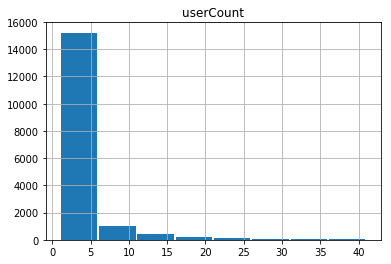

In [20]:
unique_users_by_artist = user_artists.groupby("artistID")\
                            .userID.agg(["count"])\
                            .rename(columns={"name": "artistName", "count": "userCount"})

# Again, exclude artists with more than 45 users because it makes the histogram more
# readable. And those artists with more than 45 users only represent 2% of all the artists.
unique_users_by_artist\
    .hist("userCount", bins=np.arange(1, 45, 5), rwidth=.95)

### Plot the distribution of play counts per user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C580CF2400>]],
      dtype=object)

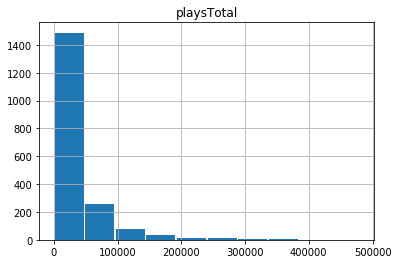

In [21]:
### Plot the distribution of play counts per user
play_counts_by_user = user_artists.groupby("userID")\
                            .weight.agg(["sum"])\
                            .rename(columns={"sum": "playsTotal"})

play_counts_by_user\
    .hist("playsTotal", rwidth=.95)

### Plot the distribution of unique artists per user

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C580ED1E10>]],
      dtype=object)

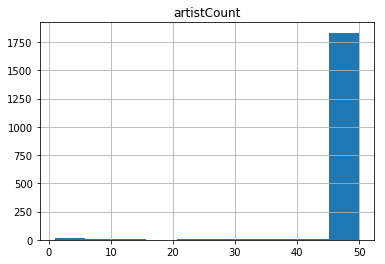

In [22]:
unique_artists_by_user = user_artists.groupby("userID")\
                            .artistID.agg(["count"])\
                            .rename(columns={"name": "artistName", "count": "artistCount"})

unique_artists_by_user\
    .hist("artistCount")

### What is the mean artists-per-user? Users-per-artist? Plays per user/artist pair?

In [23]:
print("Mean artists-per-user:", unique_artists_by_user.describe().T["mean"][0])
print("Mean users-per-artists:", unique_users_by_artist.describe().T["mean"][0])
print("Mean plays-per-user-artist-pair", sum(user_artists.weight) / len(user_artists))

Mean artists-per-user: 49.06659619450317
Mean users-per-artists: 5.265086206896552
Mean plays-per-user-artist-pair 745.2439300256372


### What are the 10 artists with the most plays?

In [24]:
pd.merge(play_counts_by_artist, artists, 
         left_on="artistID", 
         right_on="id", 
         how="inner")[["name", "playsTotal"]]\
        .sort_values("playsTotal", ascending=0)[:10]

,name,playsTotal
283,Britney Spears,2393140
66,Depeche Mode,1301308
83,Lady Gaga,1291387
286,Christina Aguilera,1058405
492,Paramore,963449
61,Madonna,921198
282,Rihanna,905423
695,Shakira,688529
221,The Beatles,662116
294,Katy Perry,532545


### What are the 10 artists with the most unique playing users?

In [25]:
pd.merge(unique_users_by_artist, artists,
        left_on="artistID", 
        right_on="id",
        how="inner")[["name", "userCount"]]\
        .sort_values("userCount", ascending=0)[:10]

,name,userCount
83,Lady Gaga,611
283,Britney Spears,522
282,Rihanna,484
221,The Beatles,480
294,Katy Perry,473
61,Madonna,429
327,Avril Lavigne,417
286,Christina Aguilera,407
184,Muse,400
492,Paramore,399


### Plotting a regression line

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [27]:
friends_by_user = user_friends.groupby("userID")\
                            .friendID.agg(["count"])\
                            .rename(columns={"count": "friendCount"})

tagged_artists_by_user = pd.DataFrame(user_tagged_artists.groupby("userID")\
                            .artistID.nunique())\
                            .rename(columns = {"artistID": "taggedArtistCount"})

user_friends_tags = pd.merge(friends_by_user, 
                             tagged_artists_by_user, 
                             on="userID", 
                             how="inner").reset_index()

In [28]:
X = user_friends_tags["friendCount"].values.reshape(-1, 1)
y = user_friends_tags["taggedArtistCount"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y)
linreg = LinearRegression().fit(X_train, y_train)

In [29]:
print("Y-intercept:", linreg.intercept_[0])
print("Beta Coefficient:",  linreg.coef_[0][0])
print("Correlation coefficient", user_friends_tags.corr()["taggedArtistCount"][1])

Y-intercept: 36.38691989609511
Beta Coefficient: -0.03844785501524338
Correlation coefficient 0.0021628759135535413


### Regression Questions

* What is the correlation between x and y?

        The correlation coefficient is .0022.

* What are the coefficients of the regression?

        The beta coefficient is .011.

* What do these values tell you about the relationship between the x and y values?

        The correlation coefficient is just barely positive. This tells me that there isn't a significant relationship between the number of friends a user has and the number of unique artists the user tags.
        
        The beta coefficient tells me that 1 unit change in X results in a .011 change in y. In other words, the number of friends a user has does not significantly predict the number of unique artists a user tags.